# Regression - predicting house prices
> A notebook exploring a housing dataset and experimenting with multiple regression models.

- toc: true 
- badges: false
- comments: true
- categories: [regression]
- image: images/regression.png
- author: Aidan Hood

## Summary
The aim of this project is to experiment with data manipulation, adequately prepare a dataset for use and apply various regression models to the manipulated data in order to build an accurate regression model. I also employed hyperparameter tuning to the best model to further increase performance.

All in all, I developed a regression model with an R2 score of ~0.87




(See libary imports below)

In [2]:
#collapse-hide
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

warnings.filterwarnings(action='ignore')
pd.set_option("max_columns", 25)

## Data input and data cleaning
The first stage is to use pandas to read in the dataset into a dataframe, investigate the data, and replace any null values with 0's.

In [3]:
df = pd.read_csv('../projects/regression/kc_house_data.csv')
df.fillna(0, inplace=True)
df



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Next, I wanted simplify the 'date' feature to just capture the year the house was recorded, and then use this in conjunction with the 'year_built' feature to create one new feature; 'age'.

In [4]:
d =[]
for i in df['date'].values:
    d.append(i[:4])
    
df['date'] = d
df['date']=df['date'].astype(float)

df['age'] = df['date'] - df['yr_built']

The next stage in data cleaning was to remove any features which were obviously redundant. Here, I removed the 'date' and 'yr_built' features which I had already simplified, alongside the 'id' feature.

In [5]:
df = df.drop(["date", "id", 'yr_built'],  axis=1)

## Removing correlated features
Next, I wrote some code to remove pairs of features which showed a high degree of correlation (>80%). I did this as my understanding is that for regression problems, multicollinearity is bad. 

After doing some more research, it seems that multicollinearity does not fundamentally worsen a model's peformance, but rather makes interpretation of coefficients/analysis of the features much harder. 

I actually found a slight decrease in peformance when removing the correlated features, so for optimal peformance this code can be commented out. I have kept the code in case I ever want to dig deeper into interpreting the influence of certain features on the model.


In [6]:
# corr_features =[]

# for i , r in df.corr().iterrows():
#     k=0
#     for j in range(len(r)):
#         if i!= r.index[k]:
#             if r.values[k] >=0.5:
#                 corr_features.append([i, r.index[k], r.values[k]])
#         k += 1

# feat =[]
# for i in corr_features:
#     if i[2] >= 0.8:
#         feat.append(i[0])
#         feat.append(i[1])

# df.drop(list(set(feat)), axis=1, inplace=True)

## Visualise the distributions of each feature
At this stage, I thought it would be useful to have a look at what each feature's distribution looks like.

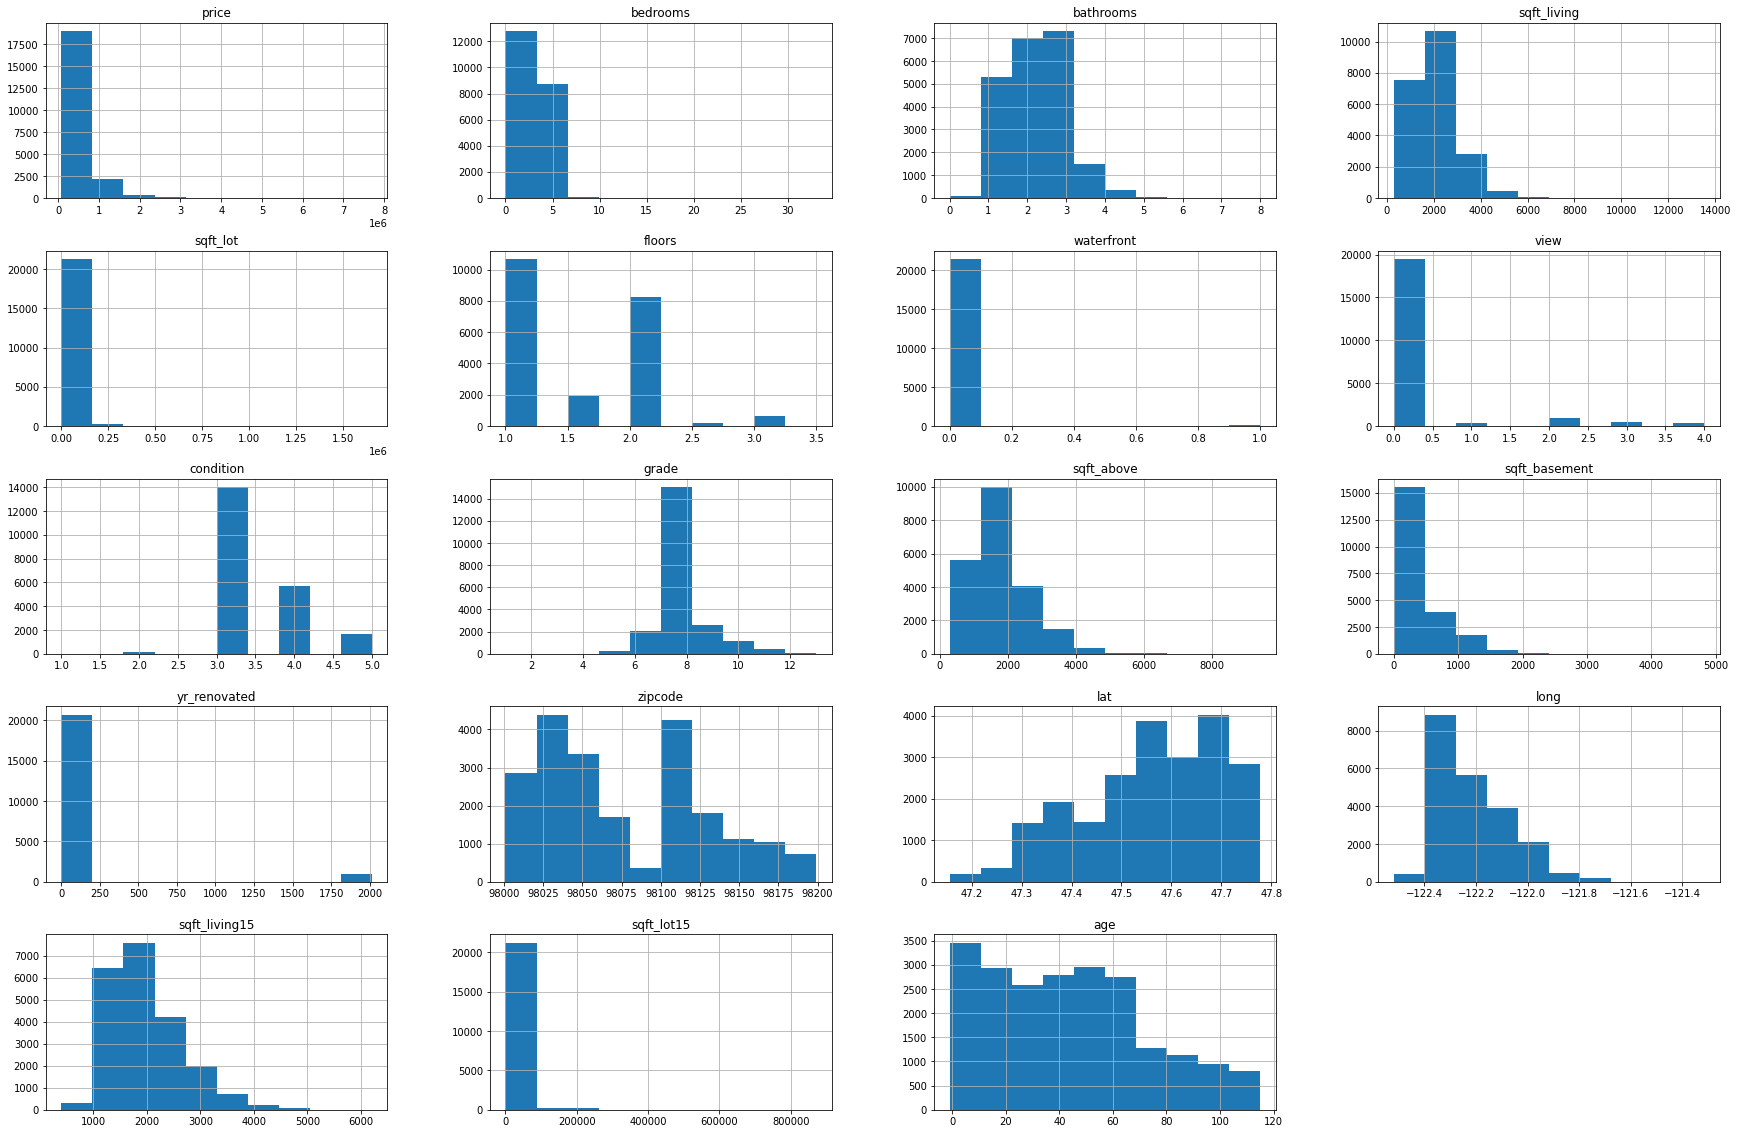

In [7]:
df.hist(figsize=(30,20))
plt.show()

## Removing outliers
I was conflicted about including this code. On one hand, removing outliers definitely improves the model's peformance. However, I am also of the opinion that almost all data holds value, so throwing some away doesn't sit great with me.

In the end I became a sucker for peformance, and decided to remove the outliers from the datasets. Beyond just peformance gains, there is rationale for doing this. Regressions are designed to summarise the data, and having outliers greatly swing the summary of the vast majority of the dataset isn't always logical. Sometimes new, outlying data points won't be described well by a model that has omitted outliers, but it should boost peformance in the general case.

In summary, this issue is something that needs to be considered in a case by case basis. As long as there is explained reason behind the decision to remove outliers (or not), then there is good justification to go either way based on the circumstances.

In terms of implementation, as the price follows a somewhat gaussian distribution, I used a standard deviation cut-off approach to removing outliers. In short, each price was normalized, and if this value was greater than or less than 3 then I removed that row from the dataset. I've also visualised the outliers, where blue is low outliers and red is high outliers.

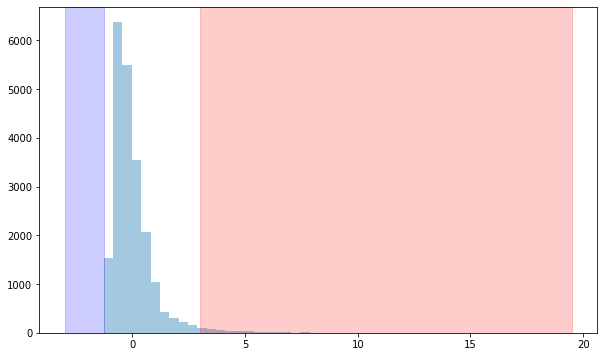

In [8]:
zscore = []
outlier =[]
threshold = 3

price_mean = np.mean(df['price'])
price_std = np.std(df['price'])

for i in df['price']:
        z = (i-price_mean)/price_std
        zscore.append(z)
        if np.abs(z) > threshold:
            outlier.append(i)


plt.figure(figsize = (10,6))
sns.distplot(zscore, kde=False)
plt.axvspan(xmin = -3 ,xmax= min(zscore),alpha=0.2, color='blue', label='Lower Outliers')
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red', label='Upper Outliers')
plt.show()

dj=[]
for i in df.price:
    if i in set(outlier):
        dj.append(0.0)
    else:
        dj.append(i)
        
df['P'] = dj

df = df.drop(df[df['P'] == 0.0].index) 


After the outliers were removed, I split the dataset into a feature set and a price set, and removed the redundant features appropriatley.

In [9]:
X = df.drop(['price','P'], axis=1)
Y = df['price']

## Preparing the training and test datasets
The first step was to easily split the dataframes into train and test sets, on a 70:30 ratio.


In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

Next, to deal with categorical values (only zipcode in this case), I employed one-hot encoding to categorical features in the feature sets.

In [11]:
train_zip = pd.get_dummies(x_train.zipcode, prefix="zipcode")
x_train = x_train.drop('zipcode',axis=1)
x_train = x_train.join(train_zip)

test_zip = pd.get_dummies(x_test.zipcode, prefix="zipcode")
x_test = x_test.drop('zipcode',axis=1)
x_test = x_test.join(test_zip)

The final stage before model selection was to scale the data. I went for the StandardScaler, which implements a basic scaling based off the mean and standard deviation of the datasets. 

It is important to note that the scaling fit to the training set is the same scaling applied to the test set. This is to avoid the model learning anything about the test set before we let it attack it.

In [12]:
#collapse-output
scaler = StandardScaler()
scaler.fit(x_train)
scaler.transform(x_train)
scaler.transform(x_test)

array([[ 0.69322379, -1.47939619, -0.8889659 , ..., -0.08235545,
        -0.1159735 , -0.12065708],
       [ 0.69322379,  0.55967872,  0.23632775, ..., -0.08235545,
        -0.1159735 , -0.12065708],
       [-1.45976583, -1.47939619,  0.23632775, ..., -0.08235545,
        -0.1159735 , -0.12065708],
       ...,
       [-0.38327102, -0.45985874, -0.27843424, ..., -0.08235545,
        -0.1159735 , -0.12065708],
       [-1.45976583, -0.12001292, -1.06853403, ..., -0.08235545,
        -0.1159735 , -0.12065708],
       [ 1.7697186 , -0.12001292,  1.110226  , ..., -0.08235545,
        -0.1159735 , -0.12065708]])

## Model Selection
To start I defined a set of models which I wanted to include in my model evaluation. These included the ones I was most familiar with, or had heard good things about.

In [13]:
lr = linear_model.LinearRegression()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
e_net = linear_model.ElasticNet()
r_forest = RandomForestRegressor(n_jobs=-1)
k_neighbours = KNeighborsRegressor()
d_tree = DecisionTreeRegressor()


models = [lr, ridge, lasso, e_net, r_forest, k_neighbours, d_tree]
model_names = ['Linear', 'Ridge', 'Lasso', 'Elastic Net', 'Random Forest', 'KNN', 'Decision Tree']

Next, I created a set of cross-validation sets via the sklearn KFold validator class. This allowed me to generate a preliminary R2 score for each model via cross-validation, without having to fully test each model (which would have taken an age!).

In [17]:
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='r2')
    print(model_names[i] + ': ' + str(result.mean()) )

Linear: 0.834841451524125
Ridge: 0.834788741056295
Lasso: 0.8348479388140282
Elastic Net: 0.6154086881998547
Random Forest: 0.868900272979691
KNN: 0.4468420436933553
Decision Tree: 0.742939379397493


## Hyperparameter tuning
Random Forest Regression came out top, with the highest R2 score. As such, in the intertest of time, I made the assumption that once tuned, this would still be the highest peforming model.

In this step, I chose the three most prudent parameters which I thought would affect the peformance of the model; number of trees, criterion (function which measures the quality of a split) and number of features considered when looking for optimal splits.



In [18]:
parameters = {
    'n_estimators': [10, 50, 100],
    'criterion': ['mse', 'mae'],
    'max_features': ['auto', 'sqrt', 'log2'],
            }

Next, I used GridSearchCV to find the optimal set of my selected parameters; 200, mae and auto respectivley. Admittedly the first of these, number of estimators, was always going to be the largest value, so this could have been omitted from the search. If I wanted to optimise efficiency I could have plotted the peformance as a function of the number of estimators and found the point at which peformance gains become minimal.

In [19]:
grid = GridSearchCV(r_forest, param_grid = parameters,n_jobs=-1, scoring='r2', verbose=2)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_params_)  

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 23.0min finished
0.8686275134918929
{'criterion': 'mse', 'max_features': 'auto', 'n_estimators': 100}


## Final Model
Now that I have selected the optimal model and tuned its parameters, its a simple process to train and use the model on the dataset. I've printed the R2 score here for completeness.

Note that I have included an extra parameter 'n_jobs' which defines how many concurrent processes to run; -1 uses all available CPU cores so *shoud* speed it up!

In [14]:
r_forest = RandomForestRegressor(criterion='mse', max_features='auto', n_estimators=100,n_jobs=-1)
r_forest.fit(x_train,y_train)
predictions = r_forest.predict(x_test)
score = r2_score(y_test,predictions)
print(score)

0.8701934934737463


Finally, I can use the model to make a new price prediction of a new dummy data point (for ease I have made a new dummy point that is the average values across all the testing set data points).

In [15]:
new_pred = r_forest.predict([np.array(x_test).mean(axis=0)])
print(new_pred)

[568417.02]


## Feature Importance
As an added bonus, I have taken a look at how significant each feature was in the model. Firstly, I plotted all feature importances, and saw that the zipcode features (which were numerous, at the end of the feature list) had low significance.

<BarContainer object of 87 artists>

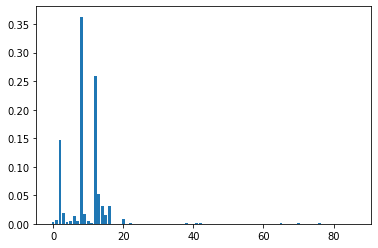

In [18]:
feature_importances = r_forest.feature_importances_
plt.bar([x for x in range(len(feature_importances))], feature_importances)

Removing these from the chart allows us a better view of feature significance.

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age']


<BarContainer object of 17 artists>

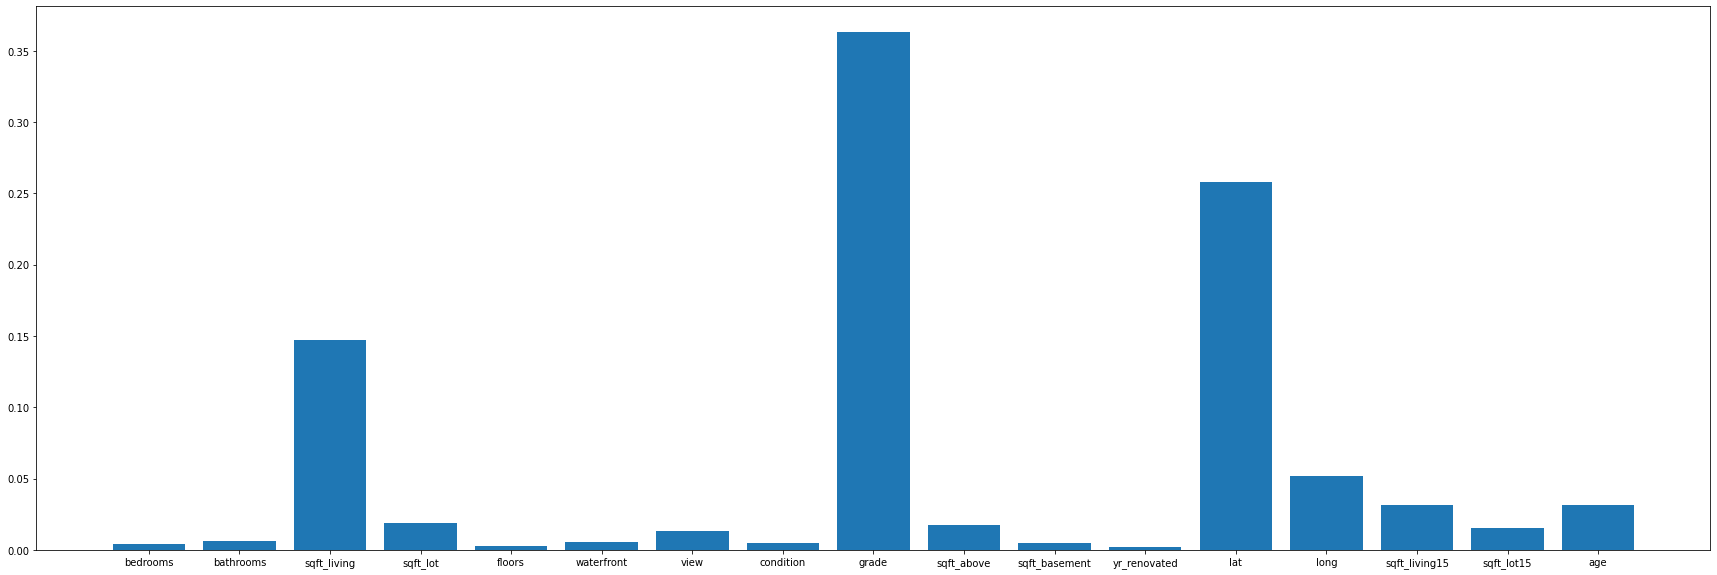

In [26]:

importances_no_zips = feature_importances[0:17]

relevant_features = x_train.columns.tolist()[0:17]

print(relevant_features)

fig = plt.figure(figsize=[30,10])
plt.bar(relevant_features, importances_no_zips)

This shows a relatively high importance for the living space feature, the grade feature, and , surpisingly, the latitude feature. This being said, geographical location is a big driver of house prices, and tree based regression methods would use longitude and latitude effectivley to predict pricing.

Linear regressions and other regression models may focus on other features, and their importances could be derived in a similar way to the above if different models were chosen.


## Conclusion
In this notebook I have experimented with regression models, and found an optimal model to use on the housing dataset. The process included data manipulation/feature selection, oulier removal, correlated feature removal, feature scaling, cross-validation to select the best type of model, hyperparameter tuning, utilisation of the tuned model and finally, an analysis of feature significance.

Final R2 scores sat at roughly 0.87. To improve this I could look into further feature selection, or perhaps dimensionality reduction. There is also the prospect of utilising a neural network, but that may be overkill here and I cannot imagine there would be a significant peformance gain.

I welcome any feedback, comments or suggestions for improvement!